<a href="https://colab.research.google.com/github/byronacunia/UFCA_estudo_mercado_livre/blob/main/UFCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analise Mercado Cativo

## Passo 1: Definição do tipo de Contrato

*   **Tipo de Contrato:** Vigencia única (Flat)
*   **Tipo de Consumidor:** Especial
*   **Energia Incentivada:** 50%, 80%, 100%



## Passo 2: Cálculo do valor da TUSD no cativo

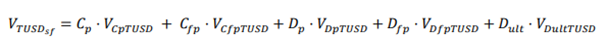

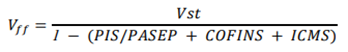

In [30]:
!git clone https://github.com/byronacunia/UFCA_estudo_mercado_livre.git

Cloning into 'UFCA_estudo_mercado_livre'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 35 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (35/35), done.


In [31]:
import pandas as pd

In [32]:
abas_de_excel =  pd.ExcelFile("/content/UFCA_estudo_mercado_livre/Raw Data/UFCA.xlsx")
abas_de_excel.sheet_names

['Apresentação', 'UC1', 'UC2', 'UC3', 'UC4']

In [33]:
UC1 = abas_de_excel.parse("UC1")
UC2 = abas_de_excel.parse("UC2")
UC3 = abas_de_excel.parse("UC3")
UC4 = abas_de_excel.parse("UC4")

In [34]:
demanda_contratada_UC1 = 139 #[kW]
demanda_contratada_UC2 = 160 #[kW]
demanda_contratada_UC3 = 600 #[kW]
#Tarifas de consumo e usos
Tarifa_total_FP=0.40733
Tarifa_total_P=1.81318
TUSD_FP=Tarifa_total_FP*0.22
TUSD_P=Tarifa_total_P*0.74
TE_FP=Tarifa_total_FP-TUSD_FP
TE_P= Tarifa_total_P-TUSD_P
RetencaoFederal=0.0620


In [35]:
X1 = UC1[UC1['ANO']==2019][['MÊS','ENERGIA_PONTA', 'ENERGIA_FPONTA', 'DEMANDA_REGISTRADA_P', 'DEMANDA_REGISTRADA_FP', 'DEMANDA_ULTRAPASSAG', 'TAR_ULTRAPASSAG', 'TAR_TUSD_KW_FP', 'TAR_DEMANDA_FP_SEM ICMS']]
X1[['DEMANDA_ULTRAPASSAG', 'TAR_ULTRAPASSAG', 'TAR_DEMANDA_FP_SEM ICMS']] = X1[['DEMANDA_ULTRAPASSAG', 'TAR_ULTRAPASSAG', 'TAR_DEMANDA_FP_SEM ICMS']].fillna(0)
X1[['Differença Demanda']] = X1[['DEMANDA_REGISTRADA_FP']] - demanda_contratada_UC1
X1[['Valor Demanda']] = (X1['DEMANDA_REGISTRADA_FP'] * X1['TAR_TUSD_KW_FP']) +(X1['Differença Demanda'] *-1* X1['TAR_DEMANDA_FP_SEM ICMS'])
X1[['Valor Consumo P+FP TUSD']] = (TUSD_FP*X1['ENERGIA_FPONTA'])+(TUSD_P*X1['ENERGIA_PONTA'])
X1[['Valor Consumo TE']] = (TE_FP*X1['ENERGIA_FPONTA'])+(TE_P*X1['ENERGIA_PONTA'])
X1[['Valor da conta no cativo']] = (X1['Valor Demanda']+X1['Valor Consumo P+FP TUSD']+X1['Valor Consumo TE'])-((X1['Valor Demanda']+X1['Valor Consumo P+FP TUSD']+X1['Valor Consumo TE'])*RetencaoFederal)
X1[['Valor consumo TUSD_P']]= (TUSD_P*X1['ENERGIA_PONTA'])
X1[['Valor consumo TUSD_FP']]= (TUSD_FP*X1['ENERGIA_FPONTA'])
TOTAL_VALOR_DEMANDA_UC1 = X1['Valor Demanda'].sum()
TOTAL_VALOR_CONSUMO_P_FP_TUSD_UC1 = X1['Valor Consumo P+FP TUSD'].sum()
TOTAL_VALOR_CONSUMO_TE_UC1 = X1['Valor Consumo TE'].sum()
TOTAL_CONTA_CATIVO_UC1 = X1['Valor da conta no cativo'].sum()
TOTAL_VALOR_CONSUMO_TUSD_P_UC1 = X1['Valor consumo TUSD_P'].sum()
TOTAL_VALOR_CONSUMO_TUSD_FP_UC1 = X1['Valor consumo TUSD_FP'].sum()
X1

,MÊS,ENERGIA_PONTA,ENERGIA_FPONTA,DEMANDA_REGISTRADA_P,DEMANDA_REGISTRADA_FP,DEMANDA_ULTRAPASSAG,TAR_ULTRAPASSAG,TAR_TUSD_KW_FP,TAR_DEMANDA_FP_SEM ICMS,Differença Demanda,Valor Demanda,Valor Consumo P+FP TUSD,Valor Consumo TE,Valor da conta no cativo,Valor consumo TUSD_P,Valor consumo TUSD_FP
52,Janeiro,1232,19079,57.12,100.80,0.00,0.00000,20.00873,14.31754,-38.20,2563.810012,3362.758738,6642.528092,11789.812838,1653.039942,1709.718795
53,Fevereiro,1077,17637,38.64,95.34,0.00,0.00000,20.25635,14.44366,-43.66,2561.850605,3025.565623,6111.308447,10973.403745,1445.068196,1580.497426
54,Março,1120,17950,28.98,109.62,0.00,0.00000,19.53986,14.07522,-29.38,2555.489417,3111.309754,6231.025346,11160.159397,1502.763584,1608.546170
55,Abril,2354,26068,87.36,144.06,0.00,0.00000,19.97938,0.00000,5.06,2878.229483,5494.508290,9391.995870,16663.320157,3158.487033,2336.021257
56,Maio,2163,22733,67.20,152.46,13.46,42.01412,21.00833,0.00000,13.46,3202.929992,4939.375407,8242.365823,15368.821606,2902.212172,2037.163236
57,Junho,2400,24845,86.94,154.14,15.14,43.80317,21.90197,0.00000,15.14,3375.969656,5446.632727,9025.113123,16741.157144,3220.207680,2226.425047
58,Julho,2316,22334,79.80,137.76,0.00,0.00000,21.86411,15.75000,-1.24,3031.529794,5108.908220,8187.724880,15315.816794,3107.500411,2001.407808
59,Agosto,1213,14889,37.80,80.64,0.00,0.00000,23.20945,16.43420,-58.36,2830.709960,2961.788633,5302.335077,10406.953982,1627.546632,1334.242001
60,Setembro,2975,26607,83.16,137.76,0.00,0.00000,22.18975,15.91935,-1.24,3076.599954,6376.038218,9856.001592,18111.504099,3991.715770,2384.322448
61,Outubro,3297,28142,110.46,140.70,0.00,0.00000,20.87043,0.00000,1.70,2936.469501,6945.638090,10495.497230,19114.193322,4423.760300,2521.877789


In [36]:
print(TOTAL_VALOR_DEMANDA_UC1)
print(TOTAL_VALOR_CONSUMO_P_FP_TUSD_UC1)
print(TOTAL_VALOR_CONSUMO_TE_UC1)
print(TOTAL_CONTA_CATIVO_UC1) 
print(TOTAL_VALOR_CONSUMO_TUSD_P_UC1) 
print(TOTAL_VALOR_CONSUMO_TUSD_FP_UC1) 

34352.0078393
58018.1958996
97769.8533604
178351.3735591434
33790.7125888
24227.4833108


In [129]:
X2 = UC2[UC2['ANO']==2019][['MÊS','ENERGIA_PONTA', 'ENERGIA_FPONTA', 'DEMANDA_REGISTRADA_P', 'DEMANDA_REGISTRADA_FP', 'DEMANDA_ULTRAPASSAG', 'TAR_ULTRAPASSAG', 'TAR_TUSD_KW_FP', 'TAR_DEMANDA_FP_SEM ICMS']]
X2[['DEMANDA_ULTRAPASSAG', 'TAR_ULTRAPASSAG', 'TAR_DEMANDA_FP_SEM ICMS']] = X2[['DEMANDA_ULTRAPASSAG', 'TAR_ULTRAPASSAG', 'TAR_DEMANDA_FP_SEM ICMS']].fillna(0)
X2[['Differença Demanda']] = X2[['DEMANDA_REGISTRADA_FP']] - demanda_contratada_UC2
X2[['Valor Demanda']] = (X2['DEMANDA_REGISTRADA_FP'] * X2['TAR_TUSD_KW_FP']) +(X2['Differença Demanda'] *-1* X2['TAR_DEMANDA_FP_SEM ICMS'])
X2[['Valor Consumo P+FP TUSD']] = (TUSD_FP*X2['ENERGIA_FPONTA'])+(TUSD_P*X2['ENERGIA_PONTA'])
X2[['Valor Consumo TE']] = (TE_FP*X2['ENERGIA_FPONTA'])+(TE_P*X2['ENERGIA_PONTA'])
X2[['Valor da conta no cativo']] = (X2['Valor Demanda']+X2['Valor Consumo P+FP TUSD']+X2['Valor Consumo TE'])-((X2['Valor Demanda']+X2['Valor Consumo P+FP TUSD']+X2['Valor Consumo TE'])*RetencaoFederal)
X2[['Valor consumo TUSD_P']]= (TUSD_P*X2['ENERGIA_PONTA'])
X2[['Valor consumo TUSD_FP']]= (TUSD_FP*X2['ENERGIA_FPONTA'])
TOTAL_VALOR_DEMANDA_UC2 = X2['Valor Demanda'].sum()
TOTAL_VALOR_CONSUMO_P_FP_TUSD_UC2 = X2['Valor Consumo P+FP TUSD'].sum()
TOTAL_VALOR_CONSUMO_TE_UC2 = X2['Valor Consumo TE'].sum()
TOTAL_CONTA_CATIVO_UC2 = X2['Valor da conta no cativo'].sum()
TOTAL_VALOR_CONSUMO_TUSD_P_UC2 = X2['Valor consumo TUSD_P'].sum()
TOTAL_VALOR_CONSUMO_TUSD_FP_UC2 = X2['Valor consumo TUSD_FP'].sum()
X2=X2.fillna(0)
X2

,MÊS,ENERGIA_PONTA,ENERGIA_FPONTA,DEMANDA_REGISTRADA_P,DEMANDA_REGISTRADA_FP,DEMANDA_ULTRAPASSAG,TAR_ULTRAPASSAG,TAR_TUSD_KW_FP,TAR_DEMANDA_FP_SEM ICMS,Differença Demanda,Valor Demanda,Valor Consumo P+FP TUSD,Valor Consumo TE,Valor da conta no cativo,Valor consumo TUSD_P,Valor consumo TUSD_FP
52,Janeiro,982.0,12205.0,28.00,53.00,0.0,0.0,20.00887,14.31729,-107.00,2592.420140,2411.323425,4340.681985,8765.071166,1317.601642,1093.721783
53,Fevereiro,1046.0,11239.0,35.28,67.62,0.0,0.0,20.25629,14.44360,-92.38,2704.030098,2410.629859,4063.938291,8609.525156,1403.473847,1007.156011
54,Março,1134.0,11988.0,33.60,78.96,0.0,0.0,19.53977,14.07564,-81.04,2683.550105,2595.823978,4343.394182,9026.156632,1521.548129,1074.275849
55,Abril,1291.0,15817.0,39.48,84.84,0.0,0.0,19.97937,14.30216,-75.16,2770.000096,3149.605875,5633.948115,10837.233733,1732.203381,1417.402494
56,Maio,1025.0,13298.0,41.16,75.18,0.0,0.0,21.61586,15.50613,-84.82,2940.310301,2566.965385,4708.218455,9582.133505,1375.297030,1191.668355
57,Junho,1470.0,15858.0,35.70,78.12,0.0,0.0,21.90169,15.76771,-81.88,3002.020118,3393.453815,5731.359925,11374.970158,1972.377204,1421.076611
58,Julho,1398.0,14605.0,39.06,75.18,0.0,0.0,21.86393,15.74794,-84.82,2979.470528,3184.562997,5299.317293,10752.623067,1875.770974,1308.792023
59,Agosto,0.0,0.0,0.00,0.00,0.0,0.0,0.00000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60,Setembro,1440.0,16531.0,43.68,86.94,0.0,0.0,22.18979,15.91623,-73.06,3092.020106,3413.510499,5931.040931,11665.504101,1932.124608,1481.385891
61,Outubro,1516.0,18084.0,47.04,88.62,0.0,0.0,20.87023,15.22583,-71.38,2936.339528,3654.652110,6460.284490,12242.097008,2034.097851,1620.554258


In [130]:
print(TOTAL_VALOR_DEMANDA_UC2)
print(TOTAL_VALOR_CONSUMO_P_FP_TUSD_UC2)
print(TOTAL_VALOR_CONSUMO_TE_UC2)
print(TOTAL_CONTA_CATIVO_UC2) 
print(TOTAL_VALOR_CONSUMO_TUSD_P_UC2) 
print(TOTAL_VALOR_CONSUMO_TUSD_FP_UC2) 


31748.2513586
34181.17073400001
59482.30472600001
117636.19975584681
19318.5625736
14862.6081604


In [131]:
X3 = UC3[UC3['ANO']==2019][['MÊS','ENERGIA_PONTA', 'ENERGIA_FPONTA','DEMANDA_CONTRATADA_P', 'DEMANDA_REGISTRADA_P', 'DEMANDA_REGISTRADA_FP', 'DEMANDA_ULTRAPASSAG', 'TAR_ULTRAPASSAG', 'TAR_TUSD_KW_FP', 'TAR_DEMANDA_FP_SEM ICMS']]
X3[['DEMANDA_ULTRAPASSAG', 'TAR_ULTRAPASSAG', 'TAR_DEMANDA_FP_SEM ICMS']] = X3[['DEMANDA_ULTRAPASSAG', 'TAR_ULTRAPASSAG', 'TAR_DEMANDA_FP_SEM ICMS']].fillna(0)
X3[['Differença Demanda']] = X3['DEMANDA_REGISTRADA_FP'] - X3['DEMANDA_CONTRATADA_P']
X3[['Valor Demanda']] = (X3['DEMANDA_REGISTRADA_FP'] * X3['TAR_TUSD_KW_FP']) +(X3['Differença Demanda'] *-1* X3['TAR_DEMANDA_FP_SEM ICMS'])
X3[['Valor Consumo P+FP TUSD']] = (TUSD_FP*X3['ENERGIA_FPONTA'])+(TUSD_P*X3['ENERGIA_PONTA'])
X3[['Valor Consumo TE']] = (TE_FP*X3['ENERGIA_FPONTA'])+(TE_P*X3['ENERGIA_PONTA'])
X3[['Valor da conta no cativo']] = (X3['Valor Demanda']+X3['Valor Consumo P+FP TUSD']+X3['Valor Consumo TE'])-((X3['Valor Demanda']+X3['Valor Consumo P+FP TUSD']+X3['Valor Consumo TE'])*RetencaoFederal)
X3[['Valor consumo TUSD_P']]= (TUSD_P*X3['ENERGIA_PONTA'])
X3[['Valor consumo TUSD_FP']]= (TUSD_FP*X3['ENERGIA_FPONTA'])
TOTAL_VALOR_DEMANDA_UC3 = X3['Valor Demanda'].sum()
TOTAL_VALOR_CONSUMO_P_FP_TUSD_UC3 = X3['Valor Consumo P+FP TUSD'].sum()
TOTAL_VALOR_CONSUMO_TE_UC3 = X3['Valor Consumo TE'].sum()
TOTAL_CONTA_CATIVO_UC3 = X3['Valor da conta no cativo'].sum()
TOTAL_VALOR_CONSUMO_TUSD_P_UC3 = X3['Valor consumo TUSD_P'].sum()
TOTAL_VALOR_CONSUMO_TUSD_FP_UC3 = X3['Valor consumo TUSD_FP'].sum()
X3

,MÊS,ENERGIA_PONTA,ENERGIA_FPONTA,DEMANDA_CONTRATADA_P,DEMANDA_REGISTRADA_P,DEMANDA_REGISTRADA_FP,DEMANDA_ULTRAPASSAG,TAR_ULTRAPASSAG,TAR_TUSD_KW_FP,TAR_DEMANDA_FP_SEM ICMS,Differença Demanda,Valor Demanda,Valor Consumo P+FP TUSD,Valor Consumo TE,Valor da conta no cativo,Valor consumo TUSD_P,Valor consumo TUSD_FP
52,jan,7760,66179,400,156.00,283.00,0.00,0.00000,20.00887,14.31726,-117.00,7337.629630,16342.477087,24684.491783,45365.993393,10412.004832,5930.472255
53,fev,4205,53186,400,154.56,297.36,0.00,0.00000,20.25639,14.44369,-102.64,7505.940472,10408.207950,18880.467330,34513.349575,5642.072206,4766.135744
54,mar,5139,63699,1200,171.36,346.08,0.00,0.00000,19.53988,0.00000,-853.92,6762.361670,12603.502702,22660.942988,39421.145304,6895.269695,5708.233007
55,abr,13212,85351,1200,288.96,451.92,0.00,0.00000,19.97940,0.00000,-748.08,9029.090448,25375.768301,33345.988689,63550.294897,17727.243278,7648.525023
56,mai,12105,80797,1200,285.60,458.64,0.00,0.00000,21.21095,0.00000,-741.36,9728.190108,23482.351728,31377.234182,60583.333905,16241.922486,7240.429242
57,jun,15548,97228,1200,295.68,443.52,0.00,0.00000,21.90197,15.76763,-756.48,21641.858477,29574.432626,38220.771254,83891.964491,20861.578754,8712.853873
58,jul,12686,85691,600,268.80,425.04,0.00,0.00000,21.86418,0.00000,-174.96,9293.151067,24700.474402,33206.042108,63033.288187,17021.481095,7678.993307
59,ago,6234,57686,600,184.80,295.68,0.00,0.00000,23.20965,0.00000,-304.32,6862.629312,13533.881892,21266.720608,39080.111440,8364.489449,5169.392444
60,set,15640,99003,600,344.40,515.76,0.00,0.00000,22.18978,15.91619,-84.24,12785.380778,29856.936286,38828.090904,76419.242674,20985.020048,8871.916238
61,out,17746,115664,600,366.24,614.88,0.00,0.00000,20.87050,0.00000,14.88,12832.853040,34175.704054,45114.405346,86411.338769,23810.752287,10364.951766


In [132]:
print(TOTAL_VALOR_DEMANDA_UC3)
print(TOTAL_VALOR_CONSUMO_P_FP_TUSD_UC3)
print(TOTAL_VALOR_CONSUMO_TE_UC3)
print(TOTAL_CONTA_CATIVO_UC3) 
print(TOTAL_VALOR_CONSUMO_TUSD_P_UC3) 
print(TOTAL_VALOR_CONSUMO_TUSD_FP_UC3)

129309.7583784
282647.6294818001
392229.47154819994
754327.2741250793
190940.87263240002
91706.7568494


In [133]:
X4 = UC4[UC4['ANO']==2019][['MÊS','ENERGIA_PONTA', 'ENERGIA_FPONTA','DEMANDA_CONTRATADA_P', 'DEMANDA_REGISTRADA_P', 'DEMANDA_REGISTRADA_FP', 'DEMANDA_ULTRAPASSAG', 'TAR_ULTRAPASSAG', 'TAR_TUSD_KW_FP', 'TAR_DEMANDA_FP_SEM ICMS']]
X4[['DEMANDA_ULTRAPASSAG', 'TAR_ULTRAPASSAG', 'TAR_DEMANDA_FP_SEM ICMS']] = X4[['DEMANDA_ULTRAPASSAG', 'TAR_ULTRAPASSAG', 'TAR_DEMANDA_FP_SEM ICMS']].fillna(0)
X4[['Differença Demanda']] = X4['DEMANDA_REGISTRADA_FP'] - X4['DEMANDA_CONTRATADA_P']
X4[['Valor Demanda']] = (X4['DEMANDA_REGISTRADA_FP'] * X4['TAR_TUSD_KW_FP']) +(X4['Differença Demanda'] *-1* X4['TAR_DEMANDA_FP_SEM ICMS'])
X4[['Valor Consumo P+FP TUSD']] = (TUSD_FP*X4['ENERGIA_FPONTA'])+(TUSD_P*X4['ENERGIA_PONTA'])
X4[['Valor Consumo TE']] = (TE_FP*X4['ENERGIA_FPONTA'])+(TE_P*X4['ENERGIA_PONTA'])
X4[['Valor da conta no cativo']] = (X4['Valor Demanda']+X4['Valor Consumo P+FP TUSD']+X4['Valor Consumo TE'])-((X4['Valor Demanda']+X4['Valor Consumo P+FP TUSD']+X4['Valor Consumo TE'])*RetencaoFederal)
X4[['Valor consumo TUSD_P']]= (TUSD_P*X4['ENERGIA_PONTA'])
X4[['Valor consumo TUSD_FP']]= (TUSD_FP*X4['ENERGIA_FPONTA'])
TOTAL_VALOR_DEMANDA_UC4 = X4['Valor Demanda'].sum()
TOTAL_VALOR_CONSUMO_P_FP_TUSD_UC4 = X4['Valor Consumo P+FP TUSD'].sum()
TOTAL_VALOR_CONSUMO_TE_UC4 = X4['Valor Consumo TE'].sum()
TOTAL_CONTA_CATIVO_UC4 = X4['Valor da conta no cativo'].sum()
TOTAL_VALOR_CONSUMO_TUSD_P_UC4 = X4['Valor consumo TUSD_P'].sum()
TOTAL_VALOR_CONSUMO_TUSD_FP_UC4 = X4['Valor consumo TUSD_FP'].sum()

In [134]:
print(TOTAL_VALOR_DEMANDA_UC4)
print(TOTAL_VALOR_CONSUMO_P_FP_TUSD_UC4)
print(TOTAL_VALOR_CONSUMO_TE_UC4)
print(TOTAL_CONTA_CATIVO_UC4) 
print(TOTAL_VALOR_CONSUMO_TUSD_P_UC4) 
print(TOTAL_VALOR_CONSUMO_TUSD_FP_UC4)

21400.240022899998
37238.82897440001
35454.6526256
88259.91088228021
30235.066608800003
7003.7623656


In [135]:
Total_UCs_2019 = TOTAL_CONTA_CATIVO_UC1+TOTAL_CONTA_CATIVO_UC2+TOTAL_CONTA_CATIVO_UC3+TOTAL_CONTA_CATIVO_UC4
Total_UCs_2019

1138574.7583223497

## Passo 3: Parcela somente da TUSD para as 4 UCs

Existe desconto na demanda e no consumo FP para mercado livre incentivado

In [136]:
X1=X1.reset_index()
X2=X2.reset_index()
X3=X3.reset_index()
X4=X4.reset_index()

In [146]:
TUSD_parcela= X1['Valor Demanda']+X1['Valor Consumo P+FP TUSD']+X2['Valor Demanda']+X2['Valor Consumo P+FP TUSD']+X3['Valor Demanda']+X3['Valor Consumo P+FP TUSD']+X4['Valor Demanda']+X4['Valor Consumo P+FP TUSD']
MEDIA_TUSD_parcela=TUSD_parcela.mean()
print(MEDIA_TUSD_parcela)

52408.00689075


In [145]:
Conta_Total_Cativo=X1['Valor da conta no cativo']+X2['Valor da conta no cativo']+X3['Valor da conta no cativo']+X4['Valor da conta no cativo']
MEDIA_Conta_Total_Cativo=Conta_Total_Cativo.mean()
print(MEDIA_Conta_Total_Cativo)

94881.22986019579


In [152]:
TUSD_Demanda_50parecela=(X1['Valor Demanda']+X2['Valor Demanda']+X3['Valor Demanda']+X4['Valor Demanda'])*0.5
MEDIA_TUSD_Demanda_50parecela=TUSD_Demanda_50parecela.mean()
print(MEDIA_TUSD_Demanda_50parecela)

9033.7607333


In [156]:
TUSD_Consumo_4855parecela=(X1['Valor consumo TUSD_FP']+X2['Valor consumo TUSD_FP']+X3['Valor consumo TUSD_FP']+X4['Valor consumo TUSD_FP'])-((X1['Valor consumo TUSD_FP']+X2['Valor consumo TUSD_FP']+X3['Valor consumo TUSD_FP']+X4['Valor consumo TUSD_FP'])*0.4855)+(X1['Valor consumo TUSD_P']+X2['Valor consumo TUSD_P']+X3['Valor consumo TUSD_P']+X4['Valor consumo TUSD_P'])
MEDIA_TUSD_Consumo_4855parecela=TUSD_Consumo_4855parecela.mean()
print(MEDIA_TUSD_Consumo_4855parecela)

28765.302383470826


In [157]:
TUSD_Consumo_9711parecela=(X1['Valor consumo TUSD_FP']+X2['Valor consumo TUSD_FP']+X3['Valor consumo TUSD_FP']+X4['Valor consumo TUSD_FP'])-((X1['Valor consumo TUSD_FP']+X2['Valor consumo TUSD_FP']+X3['Valor consumo TUSD_FP']+X4['Valor consumo TUSD_FP'])*0.9711)+(X1['Valor consumo TUSD_P']+X2['Valor consumo TUSD_P']+X3['Valor consumo TUSD_P']+X4['Valor consumo TUSD_P'])
MEDIA_TUSD_Consumo_9711parecela=TUSD_Consumo_9711parecela.mean()
print(MEDIA_TUSD_Consumo_9711parecela)

23188.971004369265


In [159]:
TUSD_TOTAL_50=TUSD_Demanda_50parecela+TUSD_Consumo_4855parecela
MEDIA_TUSD_TOTAL_50=TUSD_TOTAL_50.mean()
print(MEDIA_TUSD_TOTAL_50)

37799.06311677083


In [160]:
TUSD_TOTAL_100=0+TUSD_Consumo_9711parecela
MEDIA_TUSD_TOTAL_100=TUSD_TOTAL_100.mean()
print(MEDIA_TUSD_TOTAL_100)

23188.971004369265


## Passo 4: Breakeven

In [170]:
Consumo_Total=X1['ENERGIA_PONTA']+X1['ENERGIA_FPONTA']+X2['ENERGIA_PONTA']+X2['ENERGIA_FPONTA']+X3['ENERGIA_PONTA']+X3['ENERGIA_FPONTA']+X4['ENERGIA_PONTA']+X4['ENERGIA_FPONTA']
MEDIA_Consumo_Total=Consumo_Total.mean()
print(MEDIA_Consumo_Total)

145180.0


In [166]:
Consumo_Total

0     110454.0
1      92245.0
2     107932.0
3     153813.0
4     141015.0
5     167579.0
6     147510.0
7      85086.0
8     171878.0
9     197001.0
10    223370.0
11    144277.0
dtype: float64

In [176]:
Preço_energia_TE_50=Conta_Total_Cativo-TUSD_TOTAL_50
MEDIA_Preço_energia_TE_50=Preço_energia_TE_50.mean()
MEDIA_Preço_energia_TE_50_MWh=MEDIA_Preço_energia_TE_50/1000
print(MEDIA_Preço_energia_TE_50)

57082.166743424976


In [177]:
Preço_energia_TE_100=Conta_Total_Cativo-TUSD_TOTAL_100
MEDIA_Preço_energia_TE_100=Preço_energia_TE_100.mean()
MEDIA_Preço_energia_TE_100_MWh=MEDIA_Preço_energia_TE_100/1000
print(MEDIA_Preço_energia_TE_100)

71692.25885582654


In [175]:
BreakevenMensal_50=(Preço_energia_TE_50/(Consumo_Total/1000))
MEDIA_BreakevenMensal_50=BreakevenMensal_50.mean()
print(MEDIA_BreakevenMensal_50)

394.0947436894509


In [174]:
BreakevenMensal_100=(Preço_energia_TE_100/(Consumo_Total/1000))
MEDIA_BreakevenMensal_100=BreakevenMensal_100.mean()
print(MEDIA_BreakevenMensal_100)

496.1033049523708


## Passo 5: Mercado Livre

In [187]:
Valor_Energia_MWh=240
TOTAL_Valor_Energia_MWh=Valor_Energia_MWh*12
print(TOTAL_Valor_Energia_MWh)

2880


In [185]:
Conta_ML_50=TUSD_TOTAL_50+((Valor_Energia_MWh/1000)*Consumo_Total)
MEDIA_Conta_ML_50=Conta_ML_50.mean()
TOTAL_Conta_ML_50=Conta_ML_50.sum()
print(MEDIA_Conta_ML_50)
print(TOTAL_Conta_ML_50)


72642.26311677082
871707.1574012499


In [192]:
Conta_ML_100=TUSD_TOTAL_100+((Valor_Energia_MWh/1000)*Consumo_Total)
MEDIA_Conta_ML_100=Conta_ML_100.mean()
TOTAL_Conta_ML_100=Conta_ML_100.sum()
print(MEDIA_Conta_ML_100)
print(TOTAL_Conta_ML_100)

58032.171004369266
696386.0520524313


## Passo 6: Consolidação dos Resutados

In [196]:
print("Cativo = R$",Total_UCs_2019)
print("Livre 50% = R$",TOTAL_Conta_ML_50)
print("Livre 100% = R$",TOTAL_Conta_ML_100)
print("Econômia livre 50% = R$",Total_UCs_2019-TOTAL_Conta_ML_50)
print("Econômia livre 100% = R$",Total_UCs_2019-TOTAL_Conta_ML_100)


Cativo = R$ 1138574.7583223497
Livre 50% = R$ 871707.1574012499
Livre 100% = R$ 696386.0520524313
Econômia livre 50% = R$ 266867.6009210999
Econômia livre 100% = R$ 442188.7062699185


In [220]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure


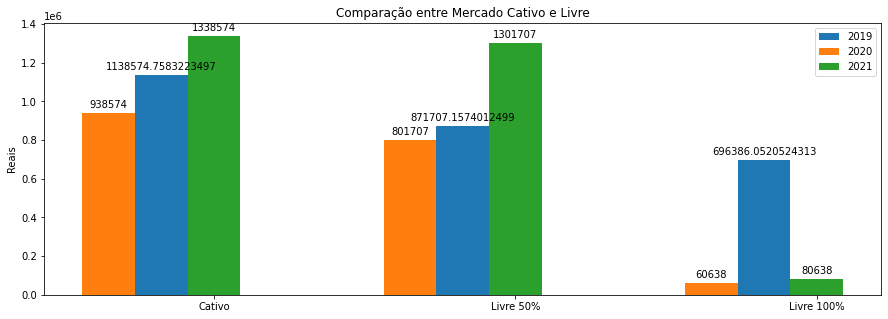

In [233]:
labels = ['Cativo', 'Livre 50%', 'Livre 100%']
Resultados_2019 = [Total_UCs_2019, TOTAL_Conta_ML_50, TOTAL_Conta_ML_100]
Resultados_2020 = [938574, 801707, 60638]
Resultados_2021 = [1338574, 1301707, 80638]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 5))
rects1 = ax.bar(x - width/2, Resultados_2019, width/2, label='2019')
rects2 = ax.bar(x - width, Resultados_2020, width/2, label='2020')
rects3 = ax.bar(x, Resultados_2021, width/2, label='2021')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Reais')
ax.set_title('Comparação entre Mercado Cativo e Livre')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

#figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
#plt.figure(figsize=(40, 20))
#fig.tight_layout()
plt.show()